<center>
<h1> Walmart Store Sales Forecasting
</center>

### Problem Definition
The objective is predicting store sales using historical markdown data.

- One challenge of modelling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

- Provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modelling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

Interference of these components produces the final series.

### Project approach: Converting the panel time series data into cross-sectional data and then predicting the sales using Regression technique

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import pandas_profiling 
import seaborn as sns


from datetime import datetime

import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Data:

In [2]:
# Importing the data
train = pd.read_csv('C:/Users/mynsh/OneDrive/Desktop/Final Projects/Case Studies/Case study (Supervised learning)/Wallmart store forecasting/data/train.csv')
feature = pd.read_csv('C:/Users/mynsh/OneDrive/Desktop/Final Projects/Case Studies/Case study (Supervised learning)/Wallmart store forecasting/data/features.csv')
test = pd.read_csv('C:/Users/mynsh/OneDrive/Desktop/Final Projects/Case Studies/Case study (Supervised learning)/Wallmart store forecasting/data/test.csv')
stores = pd.read_csv('C:/Users/mynsh/OneDrive/Desktop/Final Projects/Case Studies/Case study (Supervised learning)/Wallmart store forecasting/data/stores.csv')

In [3]:
train_t = pd.merge(train,stores) 
train = pd.merge(train_t,feature)

test_t = pd.merge(test,stores)
test= pd.merge(test_t,feature)

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [5]:
test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [6]:
print (train.info())
print ("*****************************************")
print (test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None
*******************

#### Data Description

In [7]:
train_num =train.select_dtypes(['float64', 'int64', 'float32', 'int32'])
train_cat =train.select_dtypes('object')

In [8]:
# Creating Data audit Report  
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
 
num_summary = train_num.apply(lambda x: var_summary(x)).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,421570.0,0.0,9.359084e+06,22.200546,22.00000,12.785297,1.634638e+02,1.000,1.000000,3.000000,5.000000,11.000000,22.00000,33.000000,40.000000,43.000000,45.000000,45.000000
Dept,421570.0,0.0,1.865882e+07,44.260317,37.00000,30.492054,9.297654e+02,1.000,1.000000,4.000000,7.000000,18.000000,37.00000,74.000000,92.000000,95.000000,98.000000,99.000000
Weekly_Sales,421570.0,0.0,6.737219e+09,15981.258123,7612.03000,22711.183519,5.157979e+08,-4988.940,5.000000,59.974500,291.097000,2079.650000,7612.03000,20205.852500,42845.673000,61201.951000,106479.586000,693099.360000
Size,421570.0,0.0,5.764039e+10,136727.915739,140167.00000,60980.583328,3.718632e+09,34875.000,34875.000000,39690.000000,39910.000000,93638.000000,140167.00000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,421570.0,0.0,2.533217e+07,60.090059,62.09000,18.447931,3.403262e+02,-2.060,18.300000,27.310000,33.980000,46.680000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
MarkDown1,150681.0,270889.0,1.091898e+09,7246.420196,5347.45000,8291.221345,6.874435e+07,0.270,17.760000,149.190000,375.200000,2240.270000,5347.45000,9210.900000,15282.470000,21801.350000,41524.030000,88646.760000
MarkDown2,111248.0,310322.0,3.709708e+08,3334.628621,192.00000,9475.357325,8.978240e+07,-265.760,-0.990000,1.950000,6.980000,41.600000,192.00000,1926.940000,8549.740000,16497.470000,50366.600000,104519.540000
MarkDown3,137091.0,284479.0,1.973317e+08,1439.421384,24.60000,9623.078290,9.260364e+07,-29.100,0.060000,0.650000,1.650000,5.080000,24.60000,103.990000,400.090000,1059.900000,63143.290000,141630.610000
MarkDown4,134967.0,286603.0,4.566161e+08,3383.168256,1481.31000,6292.384031,3.959410e+07,0.220,3.970000,28.760000,108.710000,504.220000,1481.31000,3595.040000,7871.420000,12645.960000,35785.260000,67474.850000


In [9]:
print('train categorical vars missing values')
print(train_cat.isnull().sum())
print('-------')
print('number of observations')
print(train_cat.count())

train categorical vars missing values
Date    0
Type    0
dtype: int64
-------
number of observations
Date    421570
Type    421570
dtype: int64


In [10]:
# test dataset
test_num =test.select_dtypes(['float64', 'int64', 'float32', 'int32'])
test_cat =test.select_dtypes('object')

In [11]:
num_summary_test=test_num.apply(lambda x: var_summary(x)).T
num_summary_test

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,115064.0,0.0,2.558817e+06,22.238207,22.000000,12.809930,1.640943e+02,1.000000,1.000000,3.0000,5.000000,11.000000,22.000000,33.000000,40.000000,43.000000,45.000000,45.000000
Dept,115064.0,0.0,5.101883e+06,44.339524,37.000000,30.656410,9.398155e+02,1.000000,1.000000,4.0000,7.000000,18.000000,37.000000,74.000000,92.000000,95.000000,98.000000,99.000000
Size,115064.0,0.0,1.570597e+10,136497.688921,140167.000000,61106.926438,3.734056e+09,34875.000000,34875.000000,39690.0000,39910.000000,93638.000000,140167.000000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,115064.0,0.0,6.206760e+06,53.941804,54.470000,18.724153,3.505939e+02,-7.290000,11.440000,23.9800,29.970000,39.820000,54.470000,67.350000,79.480000,83.820000,92.140000,101.950000
Fuel_Price,115064.0,0.0,4.121070e+05,3.581546,3.606000,0.239442,5.733244e-02,2.872000,2.957000,3.1610,3.227000,3.431000,3.606000,3.766000,3.866000,3.951000,4.079000,4.125000
MarkDown1,114915.0,149.0,8.836063e+08,7689.216439,4842.290000,10698.760716,1.144635e+08,-2781.450000,20.840000,189.4900,457.660000,1966.460000,4842.290000,9439.140000,15325.040000,23140.880000,65757.570000,103184.980000
MarkDown2,86437.0,28627.0,3.227602e+08,3734.051729,742.590000,8323.495014,6.928057e+07,-35.740000,0.020000,6.1400,25.770000,180.350000,742.590000,2735.670000,9277.290000,22671.670000,42920.210000,71074.170000
MarkDown3,105235.0,9829.0,2.528890e+08,2403.088666,78.260000,13767.939313,1.895562e+08,-179.260000,0.150000,1.1800,3.100000,15.100000,78.260000,272.580000,698.930000,2361.570000,86476.660000,149483.310000
MarkDown4,102176.0,12888.0,3.429250e+08,3356.219071,840.940000,7570.501545,5.731249e+07,0.220000,2.610000,16.9600,37.360000,155.460000,840.940000,3096.920000,7674.410000,14191.010000,44739.280000,65344.640000
MarkDown5,115064.0,0.0,4.513594e+08,3922.681189,2390.430000,19445.150745,3.781139e+08,-185.170000,269.300000,540.8900,770.883000,1309.300000,2390.430000,4227.270000,6966.340000,9316.710000,18599.300000,771448.100000


In [12]:
print('test categorical vars missing values')
print(test_cat.isnull().sum())
print('-------')
print('number of observations')
print(test_cat.count())

test categorical vars missing values
Date    0
Type    0
dtype: int64
-------
number of observations
Date    115064
Type    115064
dtype: int64


#### Missing values treatment

In [13]:
def missings(x):
    return pd.Series([x.count(),x.isnull().sum()],index = ['N',"NMISS"])

In [14]:
train.apply(missings).T

,N,NMISS
Store,421570,0
Dept,421570,0
Date,421570,0
Weekly_Sales,421570,0
IsHoliday,421570,0
Type,421570,0
Size,421570,0
Temperature,421570,0
Fuel_Price,421570,0
MarkDown1,150681,270889


In [15]:
test.apply(missings).T

,N,NMISS
Store,115064,0
Dept,115064,0
Date,115064,0
IsHoliday,115064,0
Type,115064,0
Size,115064,0
Temperature,115064,0
Fuel_Price,115064,0
MarkDown1,114915,149
MarkDown2,86437,28627


In [16]:
## Negative value check
print(train_num.apply(var_summary).T['MIN']<0)
print('-'*20)
print(test_num.apply(var_summary).T['MIN']<0)

Store           False
Dept            False
Weekly_Sales     True
Size            False
Temperature      True
Fuel_Price      False
MarkDown1       False
MarkDown2        True
MarkDown3        True
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Name: MIN, dtype: bool
--------------------
Store           False
Dept            False
Size            False
Temperature      True
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4       False
MarkDown5        True
CPI             False
Unemployment    False
Name: MIN, dtype: bool


- Since sales and promotional offers (Markdown 1,2,3,4 and 5) cannot be negative, we will replace negative values with 0
- Assuming there is no offer if not recorded, we can replace np.NAN with 0 in case of Markdowns
- In case of test filling CPI and Unemployment by median values

In [17]:
# negative Value Cleaning for train dataset 
train.loc[train.Weekly_Sales < 0 ,'Weekly_Sales'] = 0
train.loc[train.MarkDown2 < 0 ,'MarkDown2'] = 0
train.loc[train.MarkDown3 < 0, 'MarkDown3'] = 0

In [18]:
# Negative value cleaning for test dataset
test.loc[test.MarkDown1 < 0 ,'MarkDown1']= 0
test.loc[test.MarkDown2 < 0, 'MarkDown2'] = 0
test.loc[test.MarkDown3 < 0 ,'MarkDown3']= 0
test.loc[test.MarkDown5 < 0 ,'MarkDown5']= 0

In [19]:
# Missing Value treatment for test dataset other than Markdowns (CPI and Unemployment)
test['CPI'] = test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.median()))
test['Unemployment'] = test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.median()))

In [20]:
# Now we can Fill NAN Markdowns with 0
train = train.fillna(0)
test = test.fillna(0)

In [21]:
print(train.apply(missings).T)
print('-------')
print(test.apply(missings).T)

                   N  NMISS
Store         421570      0
Dept          421570      0
Date          421570      0
Weekly_Sales  421570      0
IsHoliday     421570      0
Type          421570      0
Size          421570      0
Temperature   421570      0
Fuel_Price    421570      0
MarkDown1     421570      0
MarkDown2     421570      0
MarkDown3     421570      0
MarkDown4     421570      0
MarkDown5     421570      0
CPI           421570      0
Unemployment  421570      0
-------
                   N  NMISS
Store         115064      0
Dept          115064      0
Date          115064      0
IsHoliday     115064      0
Type          115064      0
Size          115064      0
Temperature   115064      0
Fuel_Price    115064      0
MarkDown1     115064      0
MarkDown2     115064      0
MarkDown3     115064      0
MarkDown4     115064      0
MarkDown5     115064      0
CPI           115064      0
Unemployment  115064      0


#### Exploratory Data Analysis

#### Distribution of Weekly Sales (y variable)

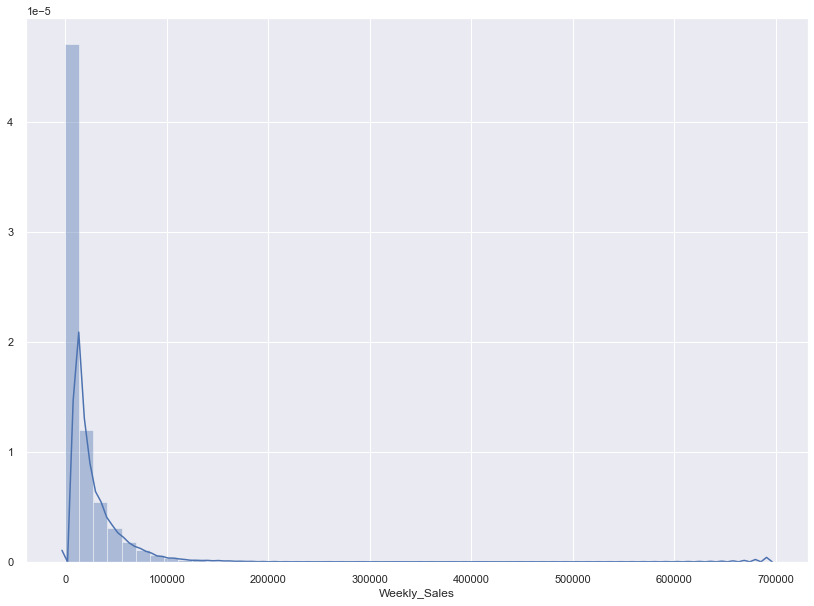

In [22]:
sns.set(rc={"figure.figsize": (14, 10)}); np.random.seed(0)
res = pd.Series(train.Weekly_Sales,name="Weekly_Sales")
plot = sns.distplot(res,kde=True)
plt.show()

#### Weekly sales vs Store

Text(0, 0.5, 'Weekly_Sales')

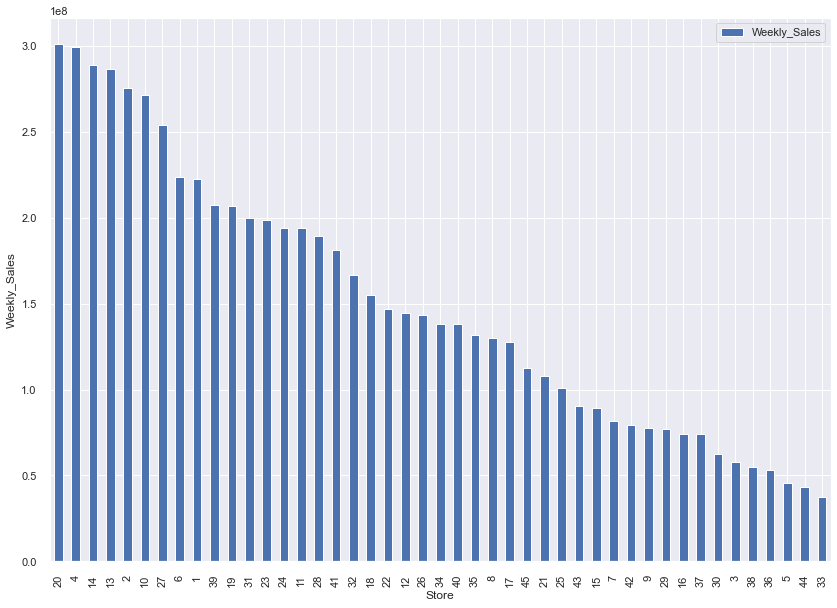

In [23]:
ax = train.groupby('Store').agg({'Weekly_Sales':"sum"}).sort_values('Weekly_Sales', ascending=False).plot(kind='bar')
ax.set_xlabel("Store")
ax.set_ylabel("Weekly_Sales")

#### Weekly sales based on Type¶

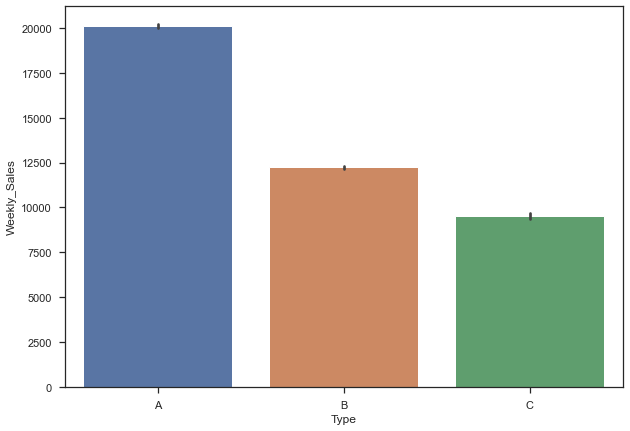

In [24]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
sns.barplot(x = 'Type',
            y = 'Weekly_Sales',
            data = train)
plt.show()

#### Department wise Weekly sales

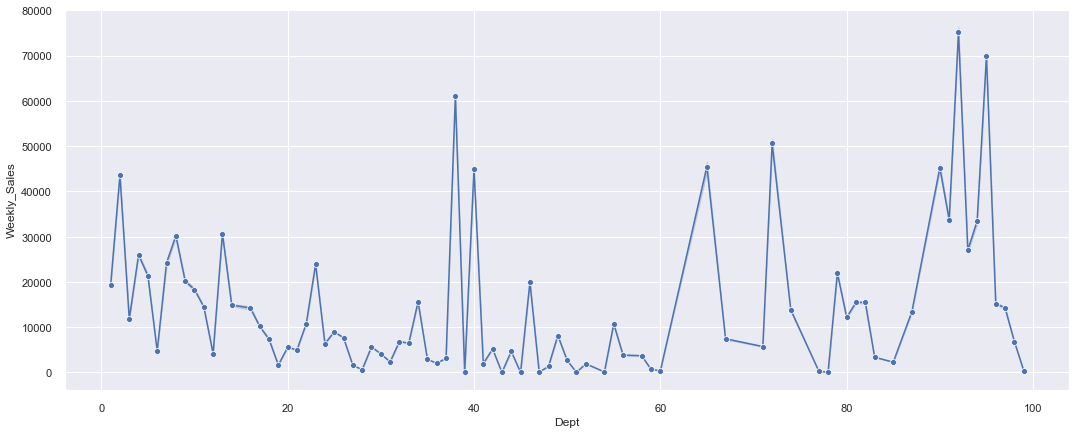

In [25]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(18,7)})
sns.lineplot(x="Dept", y="Weekly_Sales",
                          data=train,marker='o')
plt.show()

#### Outlier treatment

In [26]:
train['Weekly_Sales'] = np.where(train['Weekly_Sales']>100000,100000,train['Weekly_Sales'])

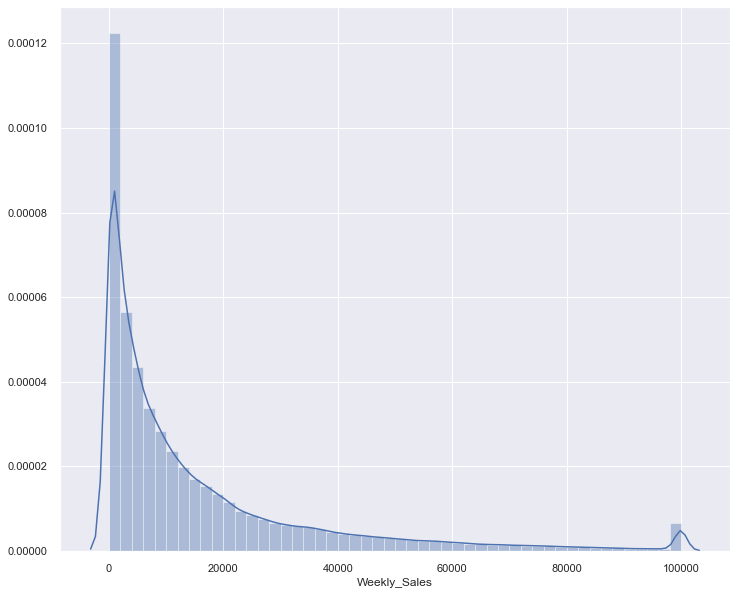

In [27]:
sns.set(rc={"figure.figsize": (12, 10)}); np.random.seed(0)
x = train.Weekly_Sales
ax = sns.distplot(x)
plt.show()

#### Correlation

In [28]:
train_corr = pd.DataFrame(train.corr())
train_corr

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.083563,-0.000548,-0.182881,-0.050097,0.065290,-0.059844,-0.033831,-0.020330,-0.042724,-0.012452,-0.211088,0.208552
Dept,0.024004,1.000000,0.141104,0.000916,-0.002966,0.004437,0.003572,0.001494,0.000587,0.001475,0.001937,0.002668,-0.007477,0.007837
Weekly_Sales,-0.083563,0.141104,1.000000,0.007726,0.253399,0.001231,0.001441,0.049528,0.022056,0.028893,0.039133,0.052510,-0.023079,-0.025364
IsHoliday,-0.000548,0.000916,0.007726,1.000000,0.000593,-0.155949,-0.078281,-0.003521,0.207602,0.266471,0.011565,-0.015235,-0.001944,0.010460
Size,-0.182881,-0.002966,0.253399,0.000593,1.000000,-0.058313,0.003361,0.169788,0.078389,0.033642,0.127334,0.153011,-0.003314,-0.068238
Temperature,-0.050097,0.004437,0.001231,-0.155949,-0.058313,1.000000,0.143859,-0.026415,-0.179680,-0.056025,-0.050281,-0.014752,0.182112,0.096730
Fuel_Price,0.065290,0.003572,0.001441,-0.078281,0.003361,0.143859,1.000000,0.297056,0.029181,0.018616,0.166622,0.215420,-0.164210,-0.033853
MarkDown1,-0.059844,0.001494,0.049528,-0.003521,0.169788,-0.026415,0.297056,1.000000,0.174876,-0.014410,0.838904,0.415050,0.010915,-0.105168
MarkDown2,-0.033831,0.000587,0.022056,0.207602,0.078389,-0.179680,0.029181,0.174876,1.000000,-0.006082,0.113250,0.131738,-0.003566,-0.041425
MarkDown3,-0.020330,0.001475,0.028893,0.266471,0.033642,-0.056025,0.018616,-0.014410,-0.006082,1.000000,-0.012020,0.042473,-0.005840,-0.018076


<AxesSubplot:>

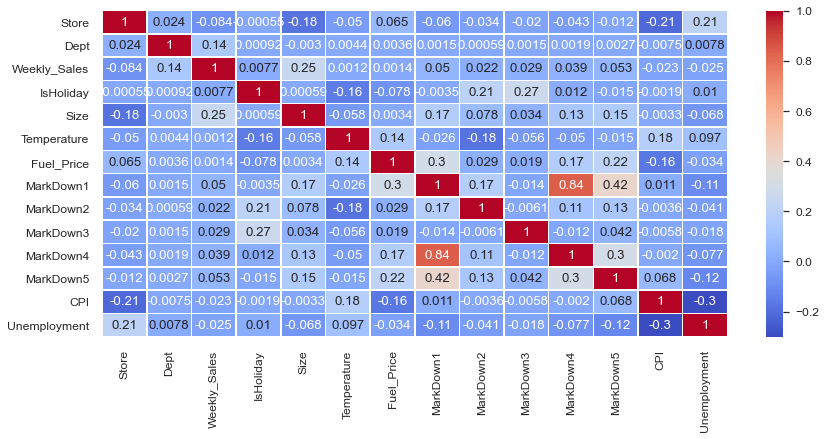

In [29]:
sns.set(rc={'figure.figsize':(14,6)}, font_scale=1.1)
sns.heatmap(train.corr(),linewidths=0.5,annot=True,cmap='coolwarm')

In [30]:
test_corr = pd.DataFrame(test.corr())
test_corr

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.019627,-0.001166,-0.186845,-0.043495,0.153425,-0.092903,-0.066749,-0.033760,-0.046755,0.010413,-0.169770,0.204803
Dept,0.019627,1.000000,0.001249,0.001502,0.003970,0.000554,-0.002416,-0.000622,-0.000163,-0.000703,0.000775,-0.046557,0.003180
IsHoliday,-0.001166,0.001249,1.000000,-0.000443,-0.187428,-0.126443,0.355389,0.245679,0.490960,0.283433,-0.019388,-0.021180,0.014800
Size,-0.186845,0.001502,-0.000443,1.000000,-0.061256,0.055088,0.310295,0.179406,0.064028,0.205812,0.103674,-0.004779,-0.001964
Temperature,-0.043495,0.003970,-0.187428,-0.061256,1.000000,0.073938,-0.170001,-0.279599,-0.053031,-0.081456,0.003938,0.233894,-0.002704
Fuel_Price,0.153425,0.000554,-0.126443,0.055088,0.073938,1.000000,0.082347,-0.139666,-0.005228,0.040605,0.012722,-0.401037,0.383401
MarkDown1,-0.092903,-0.002416,0.355389,0.310295,-0.170001,0.082347,1.000000,0.045098,-0.079524,0.807494,0.061837,-0.039730,0.021297
MarkDown2,-0.066749,-0.000622,0.245679,0.179406,-0.279599,-0.139666,0.045098,1.000000,-0.058889,-0.049466,-0.009054,-0.065106,0.005561
MarkDown3,-0.033760,-0.000163,0.490960,0.064028,-0.053031,-0.005228,-0.079524,-0.058889,1.000000,-0.047906,-0.013442,-0.030601,0.009609
MarkDown4,-0.046755,-0.000703,0.283433,0.205812,-0.081456,0.040605,0.807494,-0.049466,-0.047906,1.000000,0.031243,-0.050715,0.021814


<AxesSubplot:>

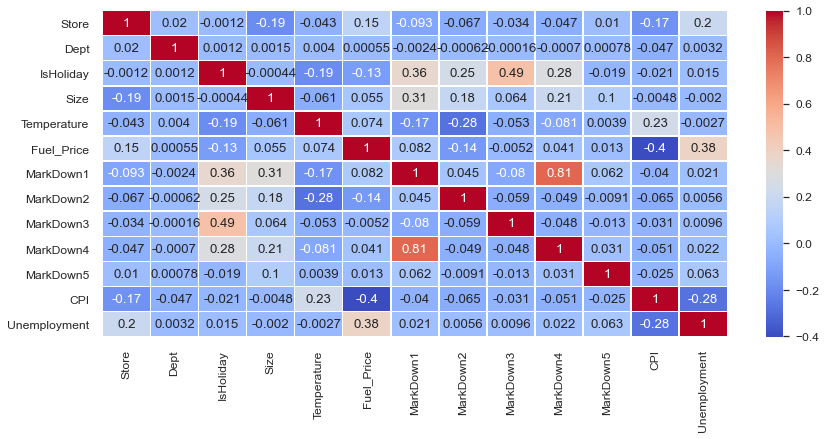

In [31]:
sns.set(rc={'figure.figsize':(14,6)}, font_scale=1.1)
sns.heatmap(test.corr(),linewidths=0.5,annot=True,cmap='coolwarm')

#### Data Preparation

In [32]:
# Temperature is in fahrenheit, changing it to celcuis scale
train['Temperature'] = (train['Temperature'] - 32) * 5/9
test['Temperature'] = (test['Temperature'] - 32) * 5/9

In [33]:
# Converting Date to datetime datatype
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [34]:
#### Extracting date features (year, month, quarter, week)
train["Week"]=train['Date'].dt.week
train["Month"]=train['Date'].dt.month
train["Year"]=train['Date'].dt.year
train["Quarter"]= train['Date'].dt.quarter

# test dataset
test["Week"]=test['Date'].dt.week
test["Month"]=test['Date'].dt.month
test["Year"]=test['Date'].dt.year
test["Quarter"]= test['Date'].dt.quarter

In [35]:
# Superbowl Dates
sb_1=np.datetime64('2010-02-12')
sb_2=np.datetime64('2011-02-11')
sb_3=np.datetime64('2012-02-10')
sb_4=np.datetime64('2013-02-08')

# labor day
lb_1=np.datetime64('2010-09-10')
lb_2=np.datetime64('2011-09-09')
lb_3=np.datetime64('2012-09-07')
lb_4=np.datetime64('2013-09-06')

# thanksgiving
tg_1=np.datetime64('2010-11-26')
tg_2=np.datetime64('2011-11-25')
tg_3=np.datetime64('2012-11-23')
tg_4=np.datetime64('2013-11-29')

# christmas day
cx_1=np.datetime64('2010-12-31')
cx_2=np.datetime64('2011-12-30')
cx_3=np.datetime64('2012-12-28')
cx_4=np.datetime64('2013-12-27')

In [36]:
# Creating new variables on train data

train['Superbowl']=np.where(((train.Date==sb_1) | (train.Date==sb_2) |
                                  (train.Date==sb_3) | (train.Date==sb_4)),1,0)

train['labor']= np.where(((train.Date==lb_1) | (train.Date==lb_2) |
                                  (train.Date==lb_3) | (train.Date==lb_4)),1,0)

train['thanksgiving']=np.where(((train.Date==tg_1) | (train.Date==tg_2) |
                                  (train.Date==tg_3) | (train.Date==tg_4)),1,0)

train['christmas']=np.where(((train.Date==cx_1) | (train.Date==cx_2) |
                             (train.Date==cx_3) | (train.Date==cx_4)),1,0)

train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,Week,Month,Year,Quarter,Superbowl,labor,thanksgiving,christmas
0,1,1,2010-02-05,24924.50,False,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
1,1,2,2010-02-05,50605.27,False,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
2,1,3,2010-02-05,13740.12,False,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
3,1,4,2010-02-05,39954.04,False,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
4,1,5,2010-02-05,32229.38,False,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0


In [37]:
# Creating new variables on test data
test['Superbowl']=np.where(((test.Date==sb_1) | (test.Date==sb_2) |
                                  (test.Date==sb_3) | (test.Date==sb_4)),1,0)

test['labor']= np.where(((test.Date==lb_1) | (test.Date==lb_2) |
                                  (test.Date==lb_3) | (test.Date==lb_4)),1,0)

test['thanksgiving']=np.where(((test.Date==tg_1) | (test.Date==tg_2) |
                                  (test.Date==tg_3) | (test.Date==tg_4)),1,0)

test['christmas']=np.where(((test.Date==cx_1) | (test.Date==cx_2) |
                             (test.Date==cx_3) | (test.Date==cx_4)),1,0)

test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,CPI,Unemployment,Week,Month,Year,Quarter,Superbowl,labor,thanksgiving,christmas
0,1,1,2012-11-02,False,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
1,1,2,2012-11-02,False,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
2,1,3,2012-11-02,False,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
3,1,4,2012-11-02,False,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
4,1,5,2012-11-02,False,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0


In [38]:
# encoding IsHoliday variable from true/false to 1/0 on train data
train['IsHoliday']=np.where((train.IsHoliday==True),1,0)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,Week,Month,Year,Quarter,Superbowl,labor,thanksgiving,christmas
0,1,1,2010-02-05,24924.50,0,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
1,1,2,2010-02-05,50605.27,0,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
2,1,3,2010-02-05,13740.12,0,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
3,1,4,2010-02-05,39954.04,0,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0
4,1,5,2010-02-05,32229.38,0,A,151315,5.727778,2.572,0.0,...,211.096358,8.106,5,2,2010,1,0,0,0,0


In [39]:
# encoding IsHoliday variable from true/false to 1/0 on test data
test['IsHoliday']=np.where((test.IsHoliday==True),1,0)
test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,CPI,Unemployment,Week,Month,Year,Quarter,Superbowl,labor,thanksgiving,christmas
0,1,1,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
1,1,2,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
2,1,3,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
3,1,4,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0
4,1,5,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.7,...,223.462779,6.573,44,11,2012,4,0,0,0,0


In [40]:
# Changing the values of Isholiday Columns according to special holidays on both train and test data
train['IsHoliday']=train['IsHoliday']|train['Superbowl']|train['labor']|train['thanksgiving']|train['christmas']
test['IsHoliday']=test['IsHoliday']|test['Superbowl']|test['labor']|test['thanksgiving']|test['christmas']

In [41]:
# Dropping the extra columns as they are redundant now
dp_list=['Superbowl', 'labor', 'thanksgiving', 'christmas']
train.drop(dp_list,inplace=True,axis=1)
test.drop(dp_list,inplace=True,axis=1)

In [42]:
test

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Month,Year,Quarter
0,1,1,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,11,2012,4
1,1,2,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,11,2012,4
2,1,3,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,11,2012,4
3,1,4,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,11,2012,4
4,1,5,2012-11-02,0,A,151315,12.955556,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,11,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,0,B,118221,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,142.960138,6.897,30,7,2013,3
115060,45,94,2013-07-26,0,B,118221,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,193.479419,6.806,30,7,2013,3
115061,45,95,2013-07-26,0,B,118221,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,192.358548,6.806,30,7,2013,3
115062,45,97,2013-07-26,0,B,118221,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,167.740846,6.884,30,7,2013,3


In [43]:
# Creating Dummy variables for Store, Dept,Type, Month, Week and Quarter
for x in ['Store','Dept','Type','Month','Week','Quarter']:
    train[x]=train[x].astype('object')
    
# for test dataset
for x in ['Store','Dept','Type','Month','Week','Quarter']:
    test[x]=test[x].astype('object')

In [44]:
# for train dataset
conti_vars_train=train.select_dtypes(['float64','int32','int64'])
cat_vars_train=train.select_dtypes('object')

# for test dataset
conti_vars_test=test.select_dtypes(['float64','int32','int64'])
cat_vars_test=test.select_dtypes('object')

In [45]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=False)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

for c_feature in cat_vars_train:
    cat_vars_train[c_feature] = cat_vars_train[c_feature].astype('category')
    cat_vars_train = create_dummies(cat_vars_train , c_feature )
    

for c_feature in cat_vars_test:
    cat_vars_test[c_feature] = cat_vars_test[c_feature].astype('category')
    cat_vars_test = create_dummies(cat_vars_test , c_feature )

C:\Users\mynsh\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mynsh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [46]:
# final dataset - train
f_train = pd.concat([conti_vars_train, cat_vars_train], axis = 1)

f_test = pd.concat([conti_vars_test, cat_vars_test], axis=1)

In [47]:
# Adding the missing variables in test dataset as compared to train data set
train_col = cat_vars_train.columns.tolist()
test_col = cat_vars_test.columns.tolist()
diff = list(set(train_col)-set(test_col))
diff

['Month_10',
 'Week_33',
 'Week_42',
 'Week_39',
 'Week_43',
 'Week_36',
 'Week_40',
 'Week_34',
 'Week_37',
 'Month_8',
 'Week_32',
 'Month_9',
 'Week_41',
 'Week_38',
 'Week_35',
 'Week_31']

In [48]:
for col in diff:
    f_test[col] = 0

In [49]:
print(f_train.shape)
print(f_test.shape)

(421570, 210)
(115064, 209)


In [50]:
# Converting all float var int integer..
for var in f_train:
    if f_train[var].dtypes == float:
        f_train[var]=f_train[var].astype(int)
        
for var in f_test:
    if f_test[var].dtypes == float:
        f_test[var]=f_test[var].astype(int)

In [51]:
f_train

,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,24924,0,151315,5,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50605,0,151315,5,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,13740,0,151315,5,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,39954,0,151315,5,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,32229,0,151315,5,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,2487,0,118221,14,3,4018,58,100,211,858,...,0,0,0,1,0,0,0,0,0,1
421566,5203,0,118221,14,3,4018,58,100,211,858,...,0,0,0,1,0,0,0,0,0,1
421567,56017,0,118221,14,3,4018,58,100,211,858,...,0,0,0,1,0,0,0,0,0,1
421568,6817,0,118221,14,3,4018,58,100,211,858,...,0,0,0,1,0,0,0,0,0,1


#### Train and Test Definition

In [52]:
# train and Test split 
train_x,test_x,train_y,test_y = train_test_split(f_train[f_train.columns.difference(['Weekly_Sales'])],f_train['Weekly_Sales'],test_size=0.3,random_state=123)

In [53]:
# test dataset whose value needs to be predicted 
TEST_X= f_test
TEST_X

,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Week_40,Week_34,Week_37,Month_8,Week_32,Month_9,Week_41,Week_38,Week_35,Week_31
0,0,151315,12,3,6766,5147,50,3639,2737,223,...,0,0,0,0,0,0,0,0,0,0
1,0,151315,12,3,6766,5147,50,3639,2737,223,...,0,0,0,0,0,0,0,0,0,0
2,0,151315,12,3,6766,5147,50,3639,2737,223,...,0,0,0,0,0,0,0,0,0,0
3,0,151315,12,3,6766,5147,50,3639,2737,223,...,0,0,0,0,0,0,0,0,0,0
4,0,151315,12,3,6766,5147,50,3639,2737,223,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,0,118221,24,3,212,851,2,10,1864,142,...,0,0,0,0,0,0,0,0,0,0
115060,0,118221,24,3,212,851,2,10,1864,193,...,0,0,0,0,0,0,0,0,0,0
115061,0,118221,24,3,212,851,2,10,1864,192,...,0,0,0,0,0,0,0,0,0,0
115062,0,118221,24,3,212,851,2,10,1864,167,...,0,0,0,0,0,0,0,0,0,0


#### Feature selection

In [54]:
#Performing RFE 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Feature extraction
model = LinearRegression()
rfe = RFE(model,50)
fit = rfe.fit(train_x,train_y)

#Creating Data Frame
Result = pd.DataFrame()
Result['Col_name'] = train_x.columns
Result['Support'] = fit.support_
Result['Rank'] = fit.ranking_
#Result.to_excel("RFE.xlsx") 
Result.sort_values(['Rank'],ascending =True)   

C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=50 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


,Col_name,Support,Rank
104,Quarter_4,True,1
154,Type_C,True,1
153,Type_B,True,1
152,Type_A,True,1
144,Store_44,True,1
...,...,...,...
88,MarkDown5,False,156
87,MarkDown4,False,157
86,MarkDown3,False,158
85,MarkDown2,False,159


In [55]:
# Feature Selection using XGboost.
import xgboost
xg =xgboost.XGBRegressor(random_state=1234)
xg = xg.fit(train_x,train_y)

# Checking accuracy for train and test data
print("Train and Test Accuracy :")
print(xg.score(train_x,train_y))
print(xg.score(test_x,test_y))

Train and Test Accuracy :
0.9445156996718012
0.9429542378085075


In [56]:
# Identifying Key variables and Printing top 50 variables.
feature_importances_XG = pd.DataFrame(xg.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
XG = pd.DataFrame(feature_importances_XG)
#XG.to_excel('XG_Features.xlsx')
XG =XG.head(50)
lis_xg= XG.index
lis_xg

Index(['Dept_95', 'Dept_92', 'Dept_38', 'Dept_40', 'Dept_90', 'Dept_91',
       'Dept_2', 'Dept_8', 'Dept_13', 'Dept_94', 'Dept_4', 'Dept_72',
       'Dept_23', 'Dept_59', 'Dept_60', 'Dept_27', 'Dept_54', 'Dept_93',
       'Dept_85', 'Dept_28', 'Dept_7', 'Dept_41', 'Dept_79', 'Dept_36',
       'Dept_52', 'Dept_31', 'Dept_19', 'Dept_46', 'Dept_35', 'Type_B',
       'Dept_83', 'Dept_56', 'Dept_5', 'Dept_10', 'Type_C', 'Dept_58',
       'Dept_9', 'Dept_37', 'Dept_1', 'Dept_12', 'Dept_45', 'Dept_30',
       'Dept_44', 'Size', 'Dept_82', 'Dept_21', 'Dept_42', 'Dept_48', 'Dept_6',
       'Dept_65'],
      dtype='object')

In [57]:
# Feature Selection using Random Forest.
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(random_state=1234,max_depth=3)
rf = rf.fit(train_x,train_y)

# Checking accuracy for train and test data
print(rf.score(train_x,train_y))
print(rf.score(test_x,test_y))

0.2973963503071255
0.30226113161817647


In [58]:
# Identifying Key variables and Printing top 50 variables.
feature_importances_RF = pd.DataFrame(rf.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
RF = pd.DataFrame(feature_importances_RF)
# RF.to_excel("RF_Features.xlsx")
RF = RF.head(50)
lis_rf= RF.index
lis_rf

Index(['Dept_95', 'Dept_92', 'Dept_38', 'Size', 'Type_C', 'Store_8',
       'Store_42', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
       'Store_40', 'Store_41', 'Store_43', 'Store_34', 'Store_44', 'Store_45',
       'Store_5', 'Store_6', 'Store_7', 'Store_9', 'Temperature', 'Type_A',
       'Type_B', 'Store_35', 'Store_33', 'Week_1', 'Store_32', 'Store_11',
       'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17',
       'Store_18', 'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22',
       'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28',
       'Store_29', 'Store_3'],
      dtype='object')

In [59]:
# Considering XGBoost Feature selection Technique
train_x = train_x[lis_xg]
test_x =test_x[lis_xg]
TEST_x = TEST_X[lis_xg]

#### Linear Regression

In [60]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr = lr.fit(train_x,train_y)

In [61]:
# Checking Accuracy for train and Test data
print(lr.score(train_x,train_y))
print(lr.score(test_x,test_y))

0.6500847547712779
0.6522202313047385


In [62]:
# Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,lr.predict(train_x)))
print(metrics.mean_squared_error(test_y, lr.predict(test_x)))
# Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,lr.predict(train_x))))
print(np.sqrt(metrics.mean_squared_error(test_y,lr.predict(test_x))))

Mean Square Error :

146690489.23184142
145903287.34896904

Root Mean Square Error :

12111.584918244243
12079.043312653906


<Figure size 288x288 with 0 Axes>

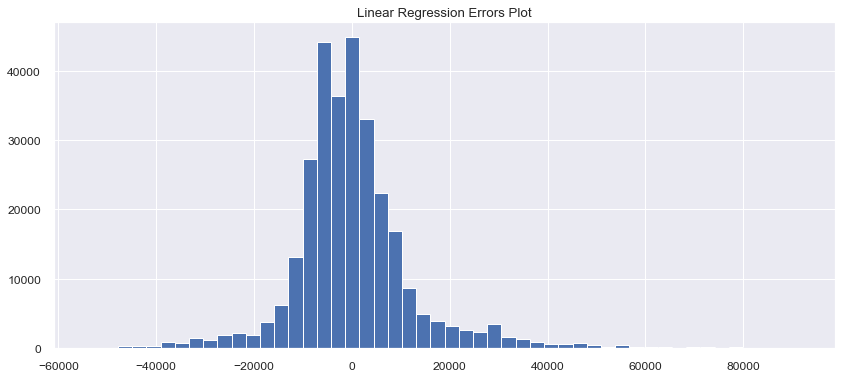

<Figure size 288x288 with 0 Axes>

In [63]:
# Checking Error Distribution :
(train_y-lr.predict(train_x)).hist(bins=50)
plt.title("Linear Regression Errors Plot")
plt.figure(figsize=(4,4))

#### Decision Trees

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble,linear_model,neighbors,metrics,tree
# decision tree with tuning parameters.
param_dt = {'max_depth': [5,6,7,8,10],'max_features':[8,12,15,20]}
dt = GridSearchCV(estimator=tree.DecisionTreeRegressor(random_state=1234), param_grid=param_dt, cv=3,verbose=True, n_jobs=-1)
dt = dt.fit(train_x,train_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [65]:
# Checking Accuracy for train and Test data
print(dt.score(train_x,train_y))
print(dt.score(test_x,test_y))

0.6372099495108468
0.6383351527610346


In [66]:
# Predicting values for train and test data sets.
pred_dt_train = dt.predict(train_x)
pred_dt_test = dt.predict(test_x)

In [67]:
# Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_dt_train))
print(metrics.mean_squared_error(test_y, pred_dt_test))
# Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_dt_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_dt_test)))

Mean Square Error :

152087829.03960785
151728464.04692757

Root Mean Square Error :

12332.38942944991
12317.810846369073


<Figure size 288x288 with 0 Axes>

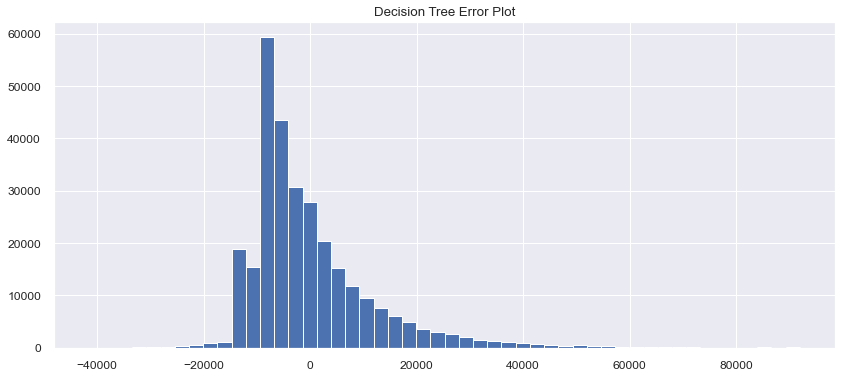

<Figure size 288x288 with 0 Axes>

In [68]:
# Checking Error Distribution :
(train_y-pred_dt_train).hist(bins=50)
plt.title("Decision Tree Error Plot")
plt.figure(figsize=(4,4))

#### XGBOOST

In [69]:
# Building Model with different tuning parameters.
import xgboost
param_xg = {'n_estimators': [100,150,200],'max_depth':[8,10]}
xg = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param_xg, cv=3,verbose=True, n_jobs=-1)
xg = xg.fit(train_x,train_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [70]:
# Checking Accuracy for train and Test data
print(xg.score(train_x,train_y))
print(xg.score(test_x,test_y))

0.8919008380960045
0.8911706568925728


In [71]:
# Predicting values for train and test
pred_xg_train = xg.predict(train_x)
pred_xg_test = xg.predict(test_x)

In [72]:
# Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_xg_train))
print(metrics.mean_squared_error(test_y,pred_xg_test))
# Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_xg_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_xg_test)))

Mean Square Error :

45317027.94167807
45656936.79932233

Root Mean Square Error :

6731.792327580974
6756.991697443644


<Figure size 288x288 with 0 Axes>

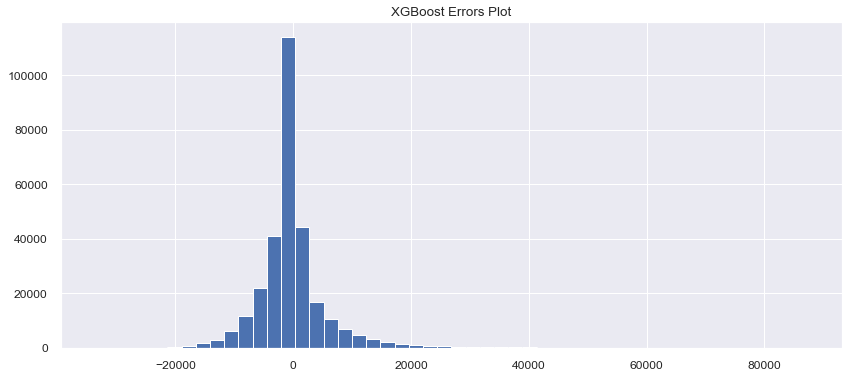

<Figure size 288x288 with 0 Axes>

In [73]:
# Checking Error Distribution :
(train_y-pred_xg_train).hist(bins=50)
plt.title("XGBoost Errors Plot")
plt.figure(figsize=(4,4))

In [74]:
# Saving model
import pickle
pickle.dump(xg,open('XGB_model','wb'))

### Random Forest

In [75]:
# Building Random Forest model with different Tuning parameters
param_rf = {'n_estimators': [100,150,200],'max_depth':[5,6,7]}
rf = GridSearchCV(estimator=ensemble.RandomForestRegressor(), param_grid=param_rf, cv=3,verbose=True, n_jobs=-1)
rf= rf.fit(train_x,train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [76]:
# Checking Accuracy for train and Test data
print(rf.score(train_x,train_y))
print(rf.score(test_x,test_y))

0.5382690863132161
0.5394406460133359


In [77]:
# Predicting values for train and test 
pred_rf_train = rf.predict(train_x)
pred_rf_test = rf.predict(test_x)

In [78]:
# Checking Mean Square Error  for Train and Test Data
print("Mean Square Error :\n")
print(metrics.mean_squared_error(train_y,pred_rf_train))
print(metrics.mean_squared_error(test_y,pred_rf_test))
# Checking Root Mean Square Error
print("\nRoot Mean Square Error :\n")
print(np.sqrt(metrics.mean_squared_error(train_y,pred_rf_train)))
print(np.sqrt(metrics.mean_squared_error(test_y,pred_rf_test)))

Mean Square Error :

193565540.64372575
193217460.63053083

Root Mean Square Error :

13912.783353582623
13900.268365414058


<Figure size 288x288 with 0 Axes>

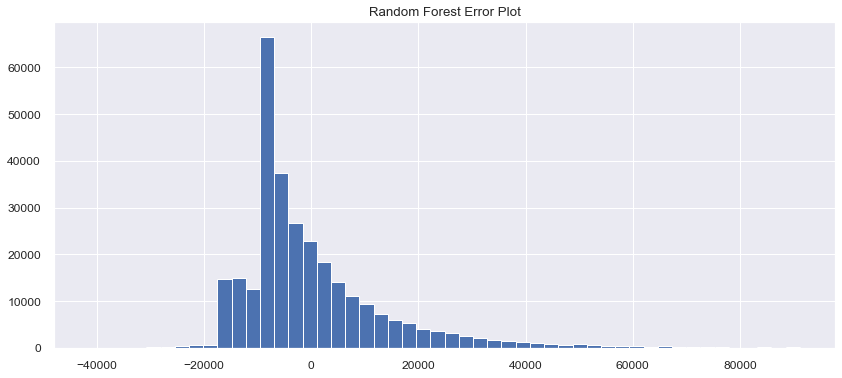

<Figure size 288x288 with 0 Axes>

In [79]:
# Checking Error Distribution :
(train_y-pred_rf_train).hist(bins=50)
plt.title("Random Forest Error Plot")
plt.figure(figsize=(4,4))

### Predicting Values for testing data

In [80]:
# Creating empty data frmae for storing results
Results = pd.DataFrame()
# Storing results
Results['Store'] = test.Store
Results['Department']= test.Dept
Results['LinearRegression_Predictions'] = lr.predict(TEST_x)
Results['DecisionTrees_Predictions'] = dt.predict(TEST_x)
Results['XGBoost_Predictions'] = xg.predict(TEST_x)
Results['RandomForest_Predictions'] = rf.predict(TEST_x)

In [81]:
#Exporting results into Excel.
Results.to_excel("Result.xlsx")

### Based on the model evaluation results, we can consider XGBoost as our best predictor and we can use this model to forecast the sales of walmart store with 89% accuracy on previous observations